# Volume 4 Midterm Project

The given ODE system is

\begin{align}
v' & = v(v-1) + \Gamma(e-ve_{-})\\
e' & = v[-(v-1)^2/2 + e - e_{-} + \Gamma e_{-}(v-1)]
\end{align}

where $\Gamma = 5/3$
\begin{align}
e_{-} = \frac{(\Gamma + 2)(v_{+} - v_{*})}{2\Gamma(\Gamma + 1)}, \quad v_{*} := \frac{\Gamma}{\Gamma + 2}
\end{align}
and $v_{+} = 3/5$

Solving for $e_{-}$ gives us  $e_{-} = 3/50$.

We solve for the fixed points of the system using the code below

In [0]:
import sympy as sy
import numpy as np
import scipy.linalg as la
import matplotlib.pyplot as plt
from scipy.integrate import odeint

In [2]:
v = sy.symbols('v')
G = 5/3.
e_ = 3/50.
e = v/G * (1 + G*e_ - v)
expr = v*((-(v-1)**2)/2 + e - e_ + G*e_*(v-1))
roots = sy.solve(expr, v)
fixed_points = []
print("The fixed points of the system is given by:")
for r in roots:
  e_val = e.subs(v, r)
  print("(v, e) = ({},{})".format(r,e_val))
  
  fixed_points.append((r, e_val))

The fixed points of the system is given by:
(v, e) = (0.0,0)
(v, e) = (0.600000000000000,0.180000000000000)
(v, e) = (1.00000000000000,0.0600000000000001)


We verify the fixed points found above

In [3]:
e = sy.symbols('e')
v_p = v*(v-1) + G*(e - v*e_)
e_p = v*(-(v-1)**2/2 + e - e_ + G*e_*(v-1))
for f in fixed_points:
  print("(v\', e\') = ({},{})".format(v_p.subs({v:f[0], e:f[1]}), e_p.subs({v:f[0], e:f[1]})))

(v', e') = (0,0)
(v', e') = (5.55111512312578E-17,0)
(v', e') = (8.32667268468867E-17,5.55111512312578E-17)


Analytically solving for the Jacobian of the system, we get:
$$
J(v, e) =
\begin{bmatrix}
2v-\Gamma e_{-} - 1 & \Gamma\\
\frac{-v(v-1)^2}{2} + e - e_{-} + \Gamma e_{-} (v-1) + v(\frac{-(v-1)^2}{2} - v(v-1) + \Gamma e_{-}) & v\\
\end{bmatrix}
$$

We numerically compute the eigenvalues at each point to observe the local behavior at each fixed points.

In [4]:
f = sy.Matrix([v_p, e_p])
J = f.jacobian([v, e])
for f in fixed_points:
  linearize = np.array(J.subs({v:f[0], e:f[1]})).astype(np.float)
  eig = la.eig(linearize)
  print("Eigenvalues of ({},{}) = {}".format(f[0],f[1],eig))

Eigenvalues of (0.0,0) = (array([-0.55+0.89302855j, -0.55-0.89302855j]), array([[0.84636421+0.j        , 0.84636421-0.j        ],
       [0.27930019+0.45349645j, 0.27930019-0.45349645j]]))
Eigenvalues of (0.600000000000000,0.180000000000000) = (array([-0.4+0.j,  1.1+0.j]), array([[-0.95782629, -0.85749293],
       [ 0.28734789, -0.51449576]]))
Eigenvalues of (1.00000000000000,0.0600000000000001) = (array([0.53870124+0.j, 1.36129876+0.j]), array([[-0.97730036, -0.96376566],
       [ 0.21185844, -0.26675034]]))


From the analysis of the eigenvalues at the fixed points, we can see that the four fixed points should be a stable spiral, saddle, and a source.

We plot the phase portrait and solutions for several initial values.

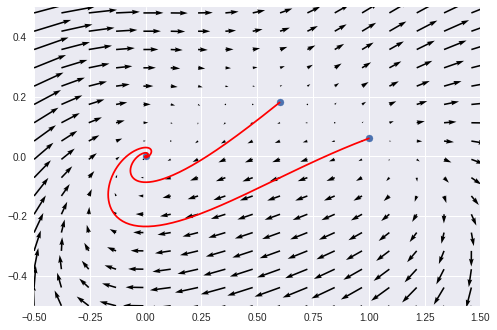

In [12]:
def ode_sys(x, t):
  dvdt = x[0]*(x[0] - 1) + G*(x[1] - x[0]*e_)
  dedt = x[0]*(-(x[0] - 1)**2/2 + x[1] - e_ + G*e_*(x[0] - 1))
  return dvdt, dedt

fixed = np.array(fixed_points).astype(np.float)
t = np.linspace(0, 30, 1000)
# Connecting orbits
con_or1 = odeint(ode_sys, fixed[1] - 1e-5, t)
con_or2 = odeint(ode_sys, fixed[2] - 1e-5, t)

# Quiver plot
Wide = False
wide_dim = [(-2, 4, 50), (-10, 10, 50)]
narrow_dim = [(-0.5, 1.5, 50), (-0.5, 0.5, 50)]
if Wide:
  # Wide view
  fig = plt.figure()
  Y1, Y2 = np.meshgrid(np.linspace(*wide_dim[0]), np.linspace(*wide_dim[1]))
  dv, de = ode_sys((Y1, Y2), 0)
  Q = plt.quiver(Y1[::3, ::3],Y2[::3, ::3],dv[::3, ::3],de[::3, ::3])
  plt.xlim(*wide_dim[0])
  plt.ylim(*wide_dim[1])
else:
  # Narrow view
  fig = plt.figure()
  Y1, Y2 = np.meshgrid(np.linspace(*narrow_dim[0]), np.linspace(*narrow_dim[1]))
  dv, de = ode_sys((Y1, Y2), 0)
  Q = plt.quiver(Y1[::3, ::3],Y2[::3, ::3],dv[::3, ::3],de[::3, ::3])
  plt.xlim(*narrow_dim[0])
  plt.ylim(*narrow_dim[1])

# Plot the fixed points
plt.scatter(fixed[:, 0], fixed[:, 1], label="fixed points")

# Connecting orbits
plt.plot(con_or1[:,0], con_or1[:,1], color='r')
plt.plot(con_or2[:,0], con_or2[:,1], color='r')

plt.show()

Create a boundary value solver class that uses collocation using Chebyshev polynomials

In [0]:
##Make a solver class.
import numpy as np
import numpy.polynomial.chebyshev as cheb
from scipy.optimize import fsolve
import matplotlib.pyplot as plt
from scipy.optimize import root

class Chebyshev_vector:
    """
    Convenience class for dealing with functions from R to R^n
    where each entry is a finite linear combination of chebyshev polynomialss.
    """
    
    def __init__(self, A, interval):
        #Just make a list with all the chebyshev polynomials in it.
        #Each row of A should have the correct coefficients.
        self.entries = [cheb.Chebyshev(row, interval) for row in A]
        
        
    def __call__(self, t):
        #Evaluate each entry at t, and then return the vector of evaluations.
        return np.array([f(t) for f in self.entries])
    
    def __getitem__(self, i):
        return self.entries[i]
    
    def setA(self, Ain):
        """
        Accomodates any value of Ain where Ain can be reshaped to the right size.
        """
        
        #Figure out the number of rows and columns we should expect
        n = len(self.entries) #number of rows
        K = len(self.entries[0].coef) #number of columns
        
        #Reshape the input to have that number of rows and columns.
        A = Ain.reshape((n, K))
        
        #Set the coefficients of each entry in our list of Chebyshev polynomials.
        for entry, row in zip(self.entries, A):
            entry.coef = row
        return
    
    def getA(self):
        #Use the other method we wrote.
        return self._getAFromEntries(self.entries)
    
    def _getAFromEntries(self, entriesParam):
        #Go through each Chebyshev polynomial and put its coefficients in a row.
        return np.array([entry.coef for entry in entriesParam])
        
    def getInterval(self):
        #Just get the domain of the first entry.  They should all be the same.
        return self.entries[0].domain
    
    def deriv(self):
        #Make a list of the derivatives of all the entries.
        derivList = [entry.deriv() for entry in self.entries]
        #Throw that list of entries into the method for getting A from the entries.
        derivA = self._getAFromEntries(derivList)
        #Create the derivative from that matrix and the interval of this thing.
        return Chebyshev_vector(derivA, self.getInterval())


class solver:
    
    def __init__(self, RHS, bc, interval, n, etol=2**-5, initialK=4):
        """
        RHS -- Right hand side of the differential equation.
        bc -- function handle for the boundary conditions.  Works like in bvp_solve
        interval -- np.array of size 2.
        n -- dimension of the system.
        etol -- error tolerance
        initialK -- initial number of Chebyshev polynomials to use.
        """
    
        self.RHS = RHS
        self.bc = bc
        
        #Make sure they didn't pass in a bogus interval.
        assert interval.size == 2 and interval[0] < interval[1]
      
        self.interval = interval
        self.n = n
        self.etol = etol
        self.K = np.max((initialK, int(2**np.ceil(np.log2(n)))))
    
    def solve(self, maxiters=5):
        
        #start out with our initial value of K
        
        for iter in range(1, maxiters+1):
            #Start out with an initial guess for what the matrix of coefficients will be
            """      if self.fixed:
                S = self.init_S()
                A = np.array([row.coef for row in S])
                self.S = Chebyshev_vector(A, self.interval)
            else:"""
            A = np.zeros((self.n, self.K))
            A[:,0] = 1. #Assume they're all constant.
            self.S = Chebyshev_vector(A, self.interval)
                
            
            #Calculate S[A]

            #Apply fsolve.
            A = root(self.H, A.ravel(), method='lm')['x'].reshape(self.n, self.K)
            self.S.setA(A)
            
            #Calculate the max error
            P = np.linspace(self.interval[0], self.interval[1], 1000)
            Sprime = self.S.deriv()
            error = np.max([np.linalg.norm(Sprime(p)-self.RHS(self.S(p))) for p in P])
            if(error < self.etol):
                return self.S
            else:
                self.K*=2
        
        print("Maximum number of iterations exceeded.")
        return self.S
        raise Exception("Maximum number of iterations exceeded.")
            
    
    def getChebyshevPoints(self):
        #See the Wikipedia article on Chebyshev nodes for this formula
        normal_roots = np.cos((2*np.arange(1, self.K) -1)/(2*self.K) * np.pi)
        a = self.interval[0]
        b = self.interval[1]
        shifted_roots = (a+b)/2 + (b-a)*normal_roots/2 #also from Wikipedia
        return shifted_roots
        
    def init_S(self):
        S = []
        for i in range(self.n):
            F = lambda t: (self.fixed[0][i] - self.fixed[1][i]) / 2 * (np.tanh(t) + 1) + self.fixed[1][i]
            S.append(cheb.Chebyshev.interpolate(F, self.K - 1, domain=[interval[0], interval[1]]))
        return S
      
    def H(self, Ain):
        #Readjust the matrix we have plugged into S[A].
        self.S.setA(Ain)
        
        #Find its derivative.
        Sprime = self.S.deriv()
        
        #Get the collocation error at the Chebyshev points.
        roots = self.getChebyshevPoints()
        root_errors = np.hstack([Sprime(r)- self.RHS(self.S(r)) for r in roots])
        #Get the error at the boundary points.
        t_1, t_2 = self.interval
        bc_error = self.bc(self.S, t_1, t_2)
        combined_error = np.hstack((root_errors, bc_error))

        return combined_error.astype(float)

Test the boundary value solver on a simple ODE

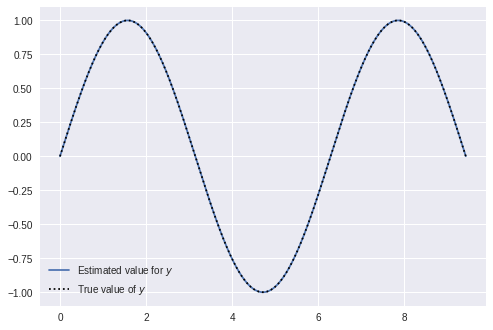

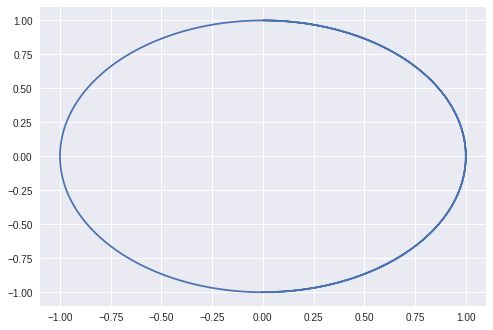

In [7]:
"""
Test on the differential equation
y'' + y = 0
y(0) = 0
y(5pi/2) = 1

The solution to this is sin(x).  We should expect that as the result of this process.

The differential equation can be changed to 
[y1]' = [0,  1]
[y2]  = [-1, 0]
"""
#define the right hand side
def RHS_0(x):
    return np.array([[0, 1], [-1, 0]]).dot(x)

  #give a function that evaluates the boundary value error
def bc_0(S, t1, t2):
    ya = S(t1)
    yb = S(t2)
    error_1 = np.array([ya[0]])
    error_2 = np.array([yb[0]-1])
    return np.hstack((error_1, error_2))

#Define the interval that you want the solution over
interval_0 = np.array([0, 5*np.pi/2])

#Give the dimension of the system.
n_0 = 2

#Create an instance of a solver object.
test_solver0 = solver(RHS_0, bc_0, interval_0, n_0)

#have the solver object find the solution.
soln = test_solver0.solve()

#Compare the real solution to the actual
t = np.linspace(0, 3*np.pi, 1000)

#soln[0] gives the Chebyshev poloynomial approximation of the first entry.
plt.plot(t, soln[0](t), label="Estimated value for $y$")
plt.plot(t, np.sin(t), 'k:',  label="True value of $y$")
plt.legend()
plt.show()

plt.plot(soln[0](t), soln[1](t))
plt.show()

Define the right hand side and the boundary conditions necessary for the solver

In [0]:
G = 5/3.
e_ = 3/50.

"""
Run BVP solver on the ODE given in the project
"""
def RHS(x):
    """
    Return the right hand side of the project ODE
    """
    dvdt = x[0]*(x[0] - 1) + G*(x[1] - x[0]*e_)
    dedt = x[0]*(-(x[0] - 1)**2/2 + x[1] - e_ + G*e_*(x[0] - 1))
    return np.array([dvdt, dedt])

  
saddle_eigs = la.eig(np.array(J.subs({v:fixed_points[1][0],e:fixed_points[1][1]})).astype(np.float))
saddle_neg = saddle_eigs[1][:,0]
saddle_pos = saddle_eigs[1][:,1]

source_eigs = la.eig(np.array(J.subs({v:fixed_points[2][0],e:fixed_points[2][1]})).astype(np.float))
source_eig1 = source_eigs[1][:,1]

perpendicular_vec = lambda e_vec: np.array([-1,1])* e_vec[::-1]
perp_vec1 = perpendicular_vec(saddle_neg)
perp_vec2 = perpendicular_vec(saddle_pos)
perp_vec3 = perpendicular_vec(source_eig1)
saddle = fixed[1]
source = fixed[2]
spiral = fixed[0]

# Boundary condition for connecting the saddle point and the source
def BC1(S, t1, t2):
    yb = S(t2)
    ya = S(t1)
    y_phase = S((t1+t2)/2)
    dot = (yb - saddle).dot(perp_vec1)
    phase = y_phase[0] - ((source[0]+saddle[0])/2 + -.1)
    return np.array([dot, phase])
# Boundary condition for connecting the saddle point and the spiral
def BC2(S, t1, t2):
    yb = S(t2)
    ya = S(t1)
    y_phase = S((t1+t2)/2)
    dot = (ya - saddle).dot(perp_vec2)
    phase = y_phase[0] - (spiral[0]+saddle[0])/2
    return np.array([dot, phase])
# Boundary condition for connecting the source and the spiral
def BC3(S, t1, t2):
    yb = S(t2)
    ya = S(t1)
    y_phase = S((t1+t2)/2)
    dot = (ya - source).dot(perp_vec3)
    phase = y_phase[0] - (spiral[0] + source[0])/2
    return np.array([dot, phase])

Solve for the solution

In [0]:
# Connecting orbits between the saddle and the source
L1 = 15
t1 = np.linspace(-L1, L1, 1000)
interval1 = np.array([-L1, L1])
sol1 = solver(RHS, BC1, interval1, 2)
soln1 = sol1.solve()
# Connecting orbits between the saddle and the spiral
L2 = 6
t2 = np.linspace(-L2, L2, 1000)
interval2 = np.array([-L2, L2])
sol2 = solver(RHS, BC2, interval2, 2)
soln2 = sol2.solve()
# Connecting orbits between the source and the spiral
L3 = 6
t3 = np.linspace(-L3, L3, 1000)
interval3 = np.array([-L3, L3])
sol3 = solver(RHS, BC3, interval3, 2)
soln3 = sol3.solve()

Plot the solution

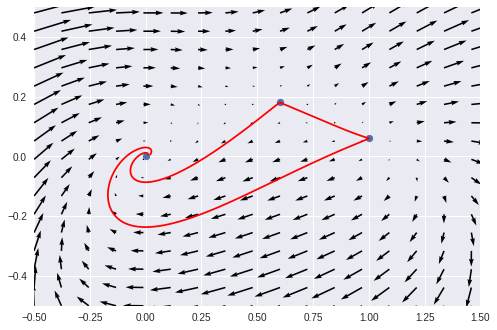

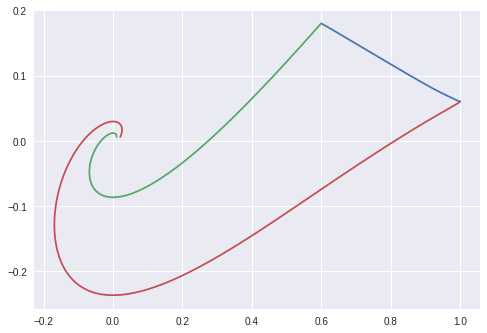

In [26]:
# Vector field
fig = plt.figure()
Y1, Y2 = np.meshgrid(np.linspace(*narrow_dim[0]), np.linspace(*narrow_dim[1]))
dv, de = ode_sys((Y1, Y2), 0)
Q = plt.quiver(Y1[::3, ::3],Y2[::3, ::3],dv[::3, ::3],de[::3, ::3])
plt.xlim(*narrow_dim[0])
plt.ylim(*narrow_dim[1])

# Plot the connecting orbits
plt.plot(soln1[0](t1), soln1[1](t1), color='r')
plt.plot(soln2[0](t2), soln2[1](t2), color='r')
plt.plot(soln3[0](t3), soln3[1](t3), color='r')
# Plot the fixed points
plt.scatter(fixed[:, 0], fixed[:, 1], label="fixed points")
plt.show()

plt.plot(soln1[0](t1), soln1[1](t1))
plt.plot(soln2[0](t2), soln2[1](t2))
plt.plot(soln3[0](t3), soln3[1](t3))
plt.show()

# Questions For Dr. Barker:

## Question 1: 
We need to find orbits between fixed points by using collocation with Chebyshev polynomials.  Orbits are trajectories from one equilibrium solution to another equilibrium solution.  That means that their domain must be $\mathbb{R}$.  However, Chebyshev polynomials can only be shifted and stretched to have domain $[a, b]$ for $a, b \in \mathbb{R}$.  How do we deal with this?

### Answer:
 
Choose a very large positive number $L$ and make your interval $[-L, L]$.

## Question 2:


We're trying to find the orbit from the source to the saddle.  One might expect the two boundary conditions to be 

$$\lim_{t \to \infty}\mathbf{x}(t) = \bigg(v_{+}, \quad \frac{1}{2} (v_{+}-1)^2 - \Gamma e_{n}(v_{+}-1) + e_n\bigg)\\
\lim_{t \to -\infty} \mathbf{x}(t) = (1, e_{-})$$

However, those infinite limits are going to be particularly nasty with Chebyshev polynomials.  What should we do?

### Answer:

We actually don't explicty set the values at $\pm \infty$.  Instead we do two crafty things to make that work out.

First, for the limit as $t \to \infty$, we try to have the solution approach along the negative eigenvector of the saddle.  To do this, suppose that the negative eigenvector is $(a, b)$ and the equilibribum solution is $\mathbf{s} = \bigg(v_{+}, \quad \frac{1}{2} (v_{+}-1)^2 - \Gamma e_{n}(v_{+}-1) + e_n\bigg)$.  We will fudge a bit and require $\mathbf{x}(L) - \mathbf{s} \in \text{span}((a, b)) = \text{span}((-b, a))^{\perp}$.  So, one of our boundary conditions ends up being

$$
(\mathbf{x}(L)- \mathbf{x}) \cdot (-b, a) = 0
$$


Second, we completely ignore the limit as $t \to -\infty$, because $(1, e_{-})$ is already a source;  In backward time everything should approach it.

However, we will still need to have some second condition, otherwise this is an initial value problem, not a boundary value problem.  To do that, we impose what is called a *phase condition*.  In our case, a phase condition specifies another point in time, because several solutions will trace out the same path, but do so at different times.  Essentially, all that amounts to is choosing one value for $v$ or one value for $e$:

$$
v(0) \in (v_+, 1) \text{ or}\\
e(0) \in \left(e_n, \quad v_{+}, \quad \frac{1}{2} (v_{+}-1)^2 - \Gamma e_{n}(v_{+}-1) + e_n\right)
$$

## Question 3:

How should we pass the interval into the boundary value solver?

### Answer:

Professor Barker recommended passing it in as a vector of size 2.

## Question 4:

The write-up says that we need to accept a function handle into our boundary value solver.
What will the function take in as an argument?
What will the function return?

### Answer

The function should look roughly like this:

``BC_fun(ya, yb, p)``

     - ya should be the value of the function at the beginning of the interval.
     - yb should be the value of the function at the end of the interval.
     
 I don't remember Professor Barker getting around to what the function should return.  He ended up telling me to just check out the function ``BVP_solve`` in the ``scipy.integrate`` package.

### Follow up question:

Our phase condition is in the middle of the interval $[-L, L]$.  So, we would have neither ``ya`` nor ``yb``.  How the heck would we include the phase condition?  Do I just solve  on $[-L, 0]$, and then solve on $[0, L]$?

### Follow up answer:

I feel like I got an ambiguous response as to whether I should solve on $[-L, 0]$ and then $[0, L]$.  I think he said something along the lines of "Maybe that would work, but perhaps instead consider doubling the size of your system."

I know he said to double the size of your system.

### Follow up question:

The SIR lab specified how to deal with a periodic function by doubling the size of your system.  However, the periodic condition involved evaluating at the endpoints.  For our phase condition, we'll be evaluating at the middle of the interval.  How do we handle that?

### Follow up answer:

Do what is called a *linear shift*.  Suppose our differential equation is $\mathbf{x}' = G(\mathbf{x})$ and the interval we are dealing with is
$[-L, L]$.  Suppose our boundary conditions are $\mathbf{x}(L) = a$ and $\mathbf{x}(0) = b$.  Create a new function $\mathbf{y}$ where $\mathbf{y}(t) = \mathbf{x}(t+L)$.  Our new boundary conditions will be $\mathbf{x}(L) = a$ and 
$\mathbf{y}(-L) = b$.  The new differential equation will be 
$$
\begin{bmatrix}
\mathbf{x}\\
\mathbf{y}
\end{bmatrix}^{'}
=
\begin{bmatrix}
G(\mathbf{x})\\
G(\mathbf{y})
\end{bmatrix}
$$

## Question 5:

The boundary value solver is supposed to accept an error tolerance.  What will that be?  A float?

### Answer

Yes, a float should work.

## Question 6

How are we supposed to measure the error?

###  Answer
 
 Dr. Barker said to use something called *residual error*.
According to him,  you sample your function at a couple points, and then calculate the error at each of those points.
 You then take the maximum of those errors.
 
 He was very vague about which points to sample.
 He just said to sample a large number of points.
 
 I didn't really realize this when I asked him, but I don't know what we're even talking about when we're talking about error at a given time value, $t$.
 Is it $\vert \mathbf{x}'(t) -  f(\mathbf{x}(t))\vert$ where $\mathbf{x}$ is the approximate solution?  Is it $\vert \mathbf{x}(t) - \mathbf{s}(t) \vert$ where $\mathbf{s}$ is the analytic solution?  Is it something else entirely?


## Question 7

How will we determine the number of Chebyshev points to sample at, given the error tolerance?

### Answer

I suggested offhand that you could take a guess at the number of points, and then measure the error.  If the error was off, then you could double the number of points and measure the error again.  You would keep on doubling until the error was within tolerance.

Dr Barker said that would work, and then said to make sure that you cut off the iterations if they got too large.

To be honest, I feel like that is a really dumb, inelegant solution.  But, Professor Barker is OK with it, and we've only got two weeks to get this together.  So, I'm just going to go for it.

## Question 8:

What should the function return?  A callable function?  An array with the values of the function at different points?

### Answer

Dr. Barker recommended returning the Chebyshev coefficients themselves.

I didn't think about it then, but now I'm a bit concerned.  The normal Chebyshev polynomials are for interpolating on the interval from -1 to 1.  Are we supposed to return the Chebyshev coefficients of the shifted/stretched versions?

## Question 9:

What will the boundary condition solver do?  Iterative vs one-shot linear system?

### Answer

Dr. Barker recommended using Newton's method.  
I asked him why we wouldn't just have a linear system.
He pointed out that the right hand side of the system was not linear.
Now I'm a bit confused about which function I would do Newton's method on, but I think it might be a function that maps from a vector of coefficients to the function created by taking a linear combination of the Chebyshev polynomials with those coefficients.  In other words

$$
f(\mathbf{a}, \mathbf{b}) =
\begin{bmatrix}
\sum_{i=1}^{n} a_i T_i
\\
\sum_{i=1}^{n} b_i T_i
\end{bmatrix}
$$

Though, I guess we'd need to actually plug that into the differential equation and take the difference with the derivative.  We'd also want to have the boundary conditions in there as well.